In [1]:
import sys
print(sys.executable)



/localdata/costamai/envs/miniconda3/envs/rvaeeeg_py310/bin/python


In [2]:
# Identify whether a CUDA-enabled GPU is available
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    msg ='CUDA-enabled GPU found. Training should be faster.'
else:
    msg = (
        "No GPU found. Training will be carried out on CPU, which might be "
        "slower.\n\nIf running on Google Colab, you can request a GPU runtime by"
        " clicking\n`Runtime/Change runtime type` in the top bar menu, then "
        "selecting \'T4 GPU\'\nunder \'Hardware accelerator\'."
    )
print(msg)
# %%


CUDA-enabled GPU found. Training should be faster.


In [3]:
from pathlib import Path

DATA_DIR = Path("/localdata/costamai/Apps/LibData/data_eegdash")

from eegdash.dataset import EEGChallengeDataset

dataset_ccd = EEGChallengeDataset(task="contrastChangeDetection",
                                  release="R5", cache_dir=DATA_DIR,
                                  mini=True,
                                  download=False)


/localdata/costamai/envs/miniconda3/envs/rvaeeeg_py310/lib/python3.10/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Using matplotlib as 2D backend.


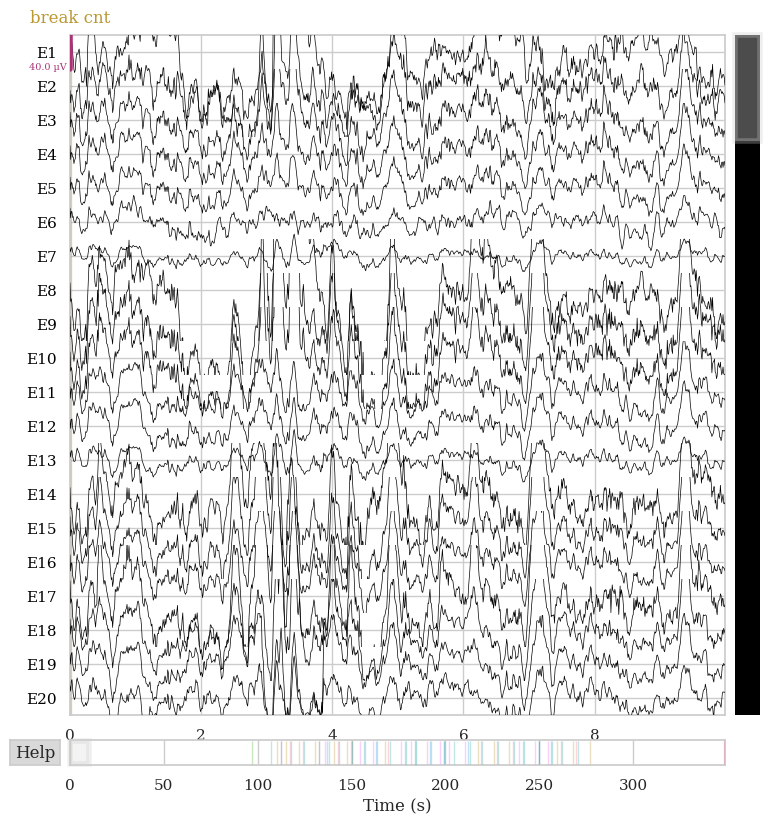

In [4]:
raw = dataset_ccd.datasets[0].raw  # get the Raw object of the first recording
fig = raw.plot()

In [7]:
len(dataset)

1743900

In [6]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

EPOCH_LEN_S = 2.0
SFREQ = 100 # by definition here

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# Create single-interval windows (stim-locked, long enough to include the response)
single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: ['stimulus_anchor']
Used Annotations descriptions: 

In [8]:
meta_information = single_windows.get_metadata()

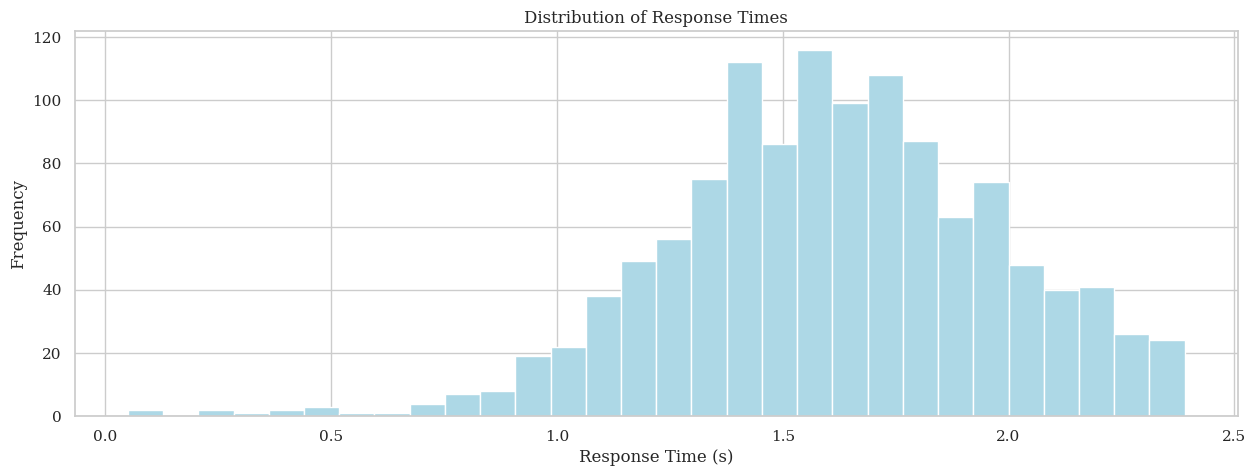

In [11]:
from matplotlib.pylab import plt

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.1
test_frac = 0.1
seed = 2025

subjects = meta_information["subject"].unique()
sub_rm = ["NDARWV769JM7", "NDARME789TD2", "NDARUA442ZVF", "NDARJP304NK1",
          "NDARTY128YLU", "NDARDW550GU6", "NDARLD243KRE", "NDARUJ292JXV", "NDARBA381JGH"]
subjects = [s for s in subjects if s not in sub_rm]

train_subj, valid_test_subject = train_test_split(
    subjects, test_size=(valid_frac + test_frac), random_state=check_random_state(seed), shuffle=True
)

valid_subj, test_subj = train_test_split(
    valid_test_subject, test_size=test_frac, random_state=check_random_state(seed + 1), shuffle=True
)
# sanity check
assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

In [14]:
from braindecode.datasets import BaseConcatDataset

# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")
print(f"Test:\t{len(test_set)}")

Number of examples in each split in the minirelease
Train:	981
Valid:	183
Test:	50


In [15]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 1 # We are using a single worker, but you can increase this for faster data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [28]:
it = iter(train_loader)
sample = next(it)
sample[0].shape, sample[1].shape

(torch.Size([128, 129, 200]), torch.Size([128, 1]))

In [16]:
from braindecode.models.util import models_dict

names = sorted(models_dict)
w = max(len(n) for n in names)

for i in range(0, len(names), 3):
    row = names[i:i+3]
    print("  ".join(f"{n:<{w}}" for n in row))

ATCNet                  AttentionBaseNet        AttnSleep             
BDTCN                   BIOT                    CTNet                 
ContraWR                Deep4Net                DeepSleepNet          
EEGConformer            EEGITNet                EEGInceptionERP       
EEGInceptionMI          EEGMiner                EEGNeX                
EEGNet                  EEGSimpleConv           EEGTCNet              
FBCNet                  FBLightConvNet          FBMSNet               
IFNet                   Labram                  MSVTNet               
SCCNet                  SPARCNet                ShallowFBCSPNet       
SignalJEPA              SignalJEPA_Contextual   SignalJEPA_PostLocal  
SignalJEPA_PreLocal     SincShallowNet          SleepStagerBlanco2020 
SleepStagerChambon2018  SyncNet                 TIDNet                
TSception               USleep                


In [24]:
# for any braindecode model, you can initialize only inputing the signal related parameters
from braindecode.models import EEGNeX

model = EEGNeX(n_chans=129, # 129 channels
                n_outputs=1, # 1 output for regression
                n_times=200, #2 seconds
                sfreq=100,      # sample frequency 100 Hz
                )
model.to(device)

EEGNeX(
  (block_1): Sequential(
    (0): Rearrange('batch ch time -> batch 1 ch time')
    (1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block_3): Sequential(
    (0): ParametrizedConv2dWithConstraint(
      32, 64, kernel_size=(129, 1), stride=(1, 1), groups=32, bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): MaxNormParametrize()
        )
      )
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=(0, 1))
    (4): Dropout(p=0.5, inplace=False)
  )
  (block_4): Sequential(
    

In [18]:
# Defining training parameters

lr = 1E-3
weight_decay = 1E-5
n_epochs = 100
early_stopping_patience = 50

In [19]:
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler

# Define a method for training one epoch
def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        # Support datasets that may return (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

In [20]:
import torch
from torch.utils.data import DataLoader
from torch.nn import Module
from tqdm import tqdm

@torch.no_grad()
def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader),
        total=n_batches,
        disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        # Supports (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()
        # casting X to float32

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse

In [25]:
import copy

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs - 1)
loss_fn = torch.nn.MSELoss()

patience = 5
min_delta = 1e-4
best_rmse = float("inf")
epochs_no_improve = 0
best_state, best_epoch = None, None

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, device
    )
    val_loss, val_rmse = valid_model(test_loader, model, loss_fn, device)

    print(
        f"Train RMSE: {train_rmse:.6f}, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Val RMSE: {val_rmse:.6f}, "
        f"Average Val Loss: {val_loss:.6f}"
    )

    if val_rmse < best_rmse - min_delta:
        best_rmse = val_rmse
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best Val RMSE: {best_rmse:.6f} (epoch {best_epoch})")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 1/100: 

Epoch 1, Batch 8/8, Loss: 2.595276, RMSE: 1.646225: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
Val Batch 1/1, Loss: 2.839203, RMSE: 1.684994: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

Val RMSE: 1.684994, Val Loss: 2.839203

Train RMSE: 1.646225, Average Train Loss: 2.705238, Val RMSE: 1.684994, Average Val Loss: 2.839203
Epoch 2/100: 


Epoch 2, Batch 8/8, Loss: 1.964345, RMSE: 1.499629: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
Val Batch 1/1, Loss: 2.454668, RMSE: 1.566738: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]

Val RMSE: 1.566738, Val Loss: 2.454668

Train RMSE: 1.499629, Average Train Loss: 2.236938, Val RMSE: 1.566738, Average Val Loss: 2.454668
Epoch 3/100: 


Epoch 3, Batch 8/8, Loss: 0.617953, RMSE: 1.029872: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
Val Batch 1/1, Loss: 0.910192, RMSE: 0.954040: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

Val RMSE: 0.954040, Val Loss: 0.910192

Train RMSE: 1.029872, Average Train Loss: 1.042046, Val RMSE: 0.954040, Average Val Loss: 0.910192
Epoch 4/100: 


Epoch 4, Batch 8/8, Loss: 0.462355, RMSE: 0.661521: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
Val Batch 1/1, Loss: 0.217577, RMSE: 0.466451: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]

Val RMSE: 0.466451, Val Loss: 0.217577

Train RMSE: 0.661521, Average Train Loss: 0.438649, Val RMSE: 0.466451, Average Val Loss: 0.217577
Epoch 5/100: 


Epoch 5, Batch 8/8, Loss: 0.335701, RMSE: 0.582868: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
Val Batch 1/1, Loss: 0.216260, RMSE: 0.465037: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

Val RMSE: 0.465037, Val Loss: 0.216260

Train RMSE: 0.582868, Average Train Loss: 0.339565, Val RMSE: 0.465037, Average Val Loss: 0.216260
Epoch 6/100: 


Epoch 6, Batch 8/8, Loss: 0.317175, RMSE: 0.546568: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
Val Batch 1/1, Loss: 0.242594, RMSE: 0.492538: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]

Val RMSE: 0.492538, Val Loss: 0.242594

Train RMSE: 0.546568, Average Train Loss: 0.299511, Val RMSE: 0.492538, Average Val Loss: 0.242594
Epoch 7/100: 


Epoch 7, Batch 8/8, Loss: 0.269472, RMSE: 0.548171: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
Val Batch 1/1, Loss: 0.255192, RMSE: 0.505165: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]

Val RMSE: 0.505165, Val Loss: 0.255192

Train RMSE: 0.548171, Average Train Loss: 0.299189, Val RMSE: 0.505165, Average Val Loss: 0.255192
Epoch 8/100: 


Epoch 8, Batch 8/8, Loss: 0.238255, RMSE: 0.535484: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
Val Batch 1/1, Loss: 0.266610, RMSE: 0.516343: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

Val RMSE: 0.516343, Val Loss: 0.266610

Train RMSE: 0.535484, Average Train Loss: 0.284707, Val RMSE: 0.516343, Average Val Loss: 0.266610
Epoch 9/100: 


Epoch 9, Batch 8/8, Loss: 0.216714, RMSE: 0.502592: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]
Val Batch 1/1, Loss: 0.268124, RMSE: 0.517807: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

Val RMSE: 0.517807, Val Loss: 0.268124

Train RMSE: 0.502592, Average Train Loss: 0.251091, Val RMSE: 0.517807, Average Val Loss: 0.268124
Epoch 10/100: 


Epoch 10, Batch 8/8, Loss: 0.274112, RMSE: 0.509618: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
Val Batch 1/1, Loss: 0.270485, RMSE: 0.520082: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]

Val RMSE: 0.520082, Val Loss: 0.270485

Train RMSE: 0.509618, Average Train Loss: 0.260316, Val RMSE: 0.520082, Average Val Loss: 0.270485
Early stopping at epoch 10. Best Val RMSE: 0.465037 (epoch 5)
